In [ ]:
import os
import sys
import time
import joblib
import numpy as np
import cv2
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential
from keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense,
    LeakyReLU, ReLU
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

DFIRE_CONFIG = {
    'fire_class_ids': [0, 1],
    'target_size': (128, 128),
    'test_size': 0.2,
    'random_state': 42,
    'img_extensions': ('.png', '.jpg', '.jpeg', '.bmp', '.gif'),
    'annotation_extension': '.txt',
    'model_dir': os.path.join('..', '..', 'models')
}

MODEL_DIR = DFIRE_CONFIG['model_dir']
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

DFIRE_ROOT = os.path.join('..', '..', 'data_subsets', 'D-Fire')
DFIRE_TEST_ROOT = os.path.join(DFIRE_ROOT, 'test')
DFIRE_TEST_IMAGES_DIR = os.path.join(DFIRE_TEST_ROOT, 'images')
DFIRE_TEST_LABELS_DIR = os.path.join(DFIRE_TEST_ROOT, 'labels')

def is_dfire_image_fire(annotation_path, fire_class_ids):
    if not os.path.exists(annotation_path):
        return False
    try:
        with open(annotation_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts and len(parts) > 0:
                    if parts[0].isdigit():
                        class_id = int(parts[0])
                        if class_id in fire_class_ids:
                            return True
    except Exception as e:
        print(f"Error reading annotation file {annotation_path}: {e}")
    return False

def load_prep_4_cnn(data_dir, config):
    all_images = []
    all_labels = []
    images_dir = os.path.join(data_dir, 'images')
    labels_dir = os.path.join(data_dir, 'labels')

    target_size = config['target_size']
    img_extensions = config['img_extensions']
    annotation_extension = config['annotation_extension']
    fire_class_ids = config['fire_class_ids']

    if not os.path.isdir(images_dir):
        print(f"Warning: Images directory not found at {images_dir}. Skipping.")
        return np.array([]), np.array([])
    if not os.path.isdir(labels_dir):
        print(f"Warning: Labels directory not found at {labels_dir}. Skipping.")
        return np.array([]), np.array([])

    image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(img_extensions)]
    if not image_files:
        print(f"Warning: No image files found in {images_dir}. Skipping.")
        return np.array([]), np.array([])

    for img_name in tqdm(image_files, desc=f"Loading & Preprocessing {os.path.basename(data_dir)}"):
        img_path = os.path.join(images_dir, img_name)
        img_name_without_ext = os.path.splitext(img_name)[0]
        annotation_path = os.path.join(labels_dir, img_name_without_ext + annotation_extension)

        label = 1 if is_dfire_image_fire(annotation_path, fire_class_ids) else 0
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img, target_size, interpolation=cv2.INTER_LINEAR)
            img_normalized = img_resized.astype(np.float32) / 255.0
            all_images.append(img_normalized)
            all_labels.append(label)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
            continue
    return np.array(all_images), np.array(all_labels)

def load_all_artifacts(dataset_choice, config):
    print(f"\n--- Loading saved CNN model for {dataset_choice} dataset ---")
    artifacts = {}
    model_path = os.path.join(config['model_dir'], 'dfire_cnn_best_model.keras')
    try:
        artifacts['cnn_model'] = tf.keras.models.load_model(model_path)
        print(f"Loaded CNN model: {os.path.basename(model_path)}")
    except Exception as e:
        print(f"Error loading CNN model from {model_path}: {e}")
        return None
    return artifacts

def fetch_original_test_split_for_cnn(data_root, config):
    print(f"\n--- Fetching original test split from '{data_root}' ---")
    all_images, all_labels = load_prep_4_cnn(data_root, config)

    if all_images.size == 0:
        print("No images loaded for test split. Check data_root and config.")
        return None, None

    X_train, X_test, y_train, y_test = train_test_split(
        all_images, all_labels,
        test_size=config['test_size'],
        random_state=config['random_state'],
        stratify=all_labels
    )
    print(f"Successfully recreated test split with {X_test.shape[0]} samples.")
    return X_test, y_test

def preprocess_image_for_cnn(image_path, config):
    target_size = config['target_size']
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Could not read image {image_path}. Skipping preprocessing.")
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, target_size)
    img_normalized = img_resized.astype(np.float32) / 255.0
    return np.expand_dims(img_normalized, axis=0)

def evaluate_folder(images_folder_path, labels_folder_path, artifacts, config):
    print(f"\n--- Processing images in folder: {images_folder_path} using CNN ---")
    cnn_model = artifacts.get('cnn_model')
    if cnn_model is None:
        print("CNN model not loaded. Cannot evaluate folder.")
        return

    all_true_labels = []
    all_predictions = []
    processed_count = 0

    if not os.path.isdir(images_folder_path):
        print(f"Error: Images folder path does not exist: {images_folder_path}")
        return
    if not os.path.isdir(labels_folder_path):
        print(f"Error: Labels folder path does not exist: {labels_folder_path}")
        return

    image_files = [f for f in os.listdir(images_folder_path) if f.lower().endswith(config['img_extensions'])]

    if not image_files:
        print(f"No images found in folder: {images_folder_path}")
        return

    for img_name in tqdm(image_files, desc="Processing folder images"):
        image_path = os.path.join(images_folder_path, img_name)
        img_name_without_ext = os.path.splitext(img_name)[0]
        annotation_path = os.path.join(labels_folder_path, img_name_without_ext + config['annotation_extension'])
        true_label = 1 if is_dfire_image_fire(annotation_path, config['fire_class_ids']) else 0
        img_preprocessed = preprocess_image_for_cnn(image_path, config)
        if img_preprocessed is None: continue
        try:
            prediction_proba = cnn_model.predict(img_preprocessed, verbose=0)
            prediction = (prediction_proba > 0.5).astype(int)[0][0]

            all_true_labels.append(true_label)
            all_predictions.append(prediction)
            processed_count += 1
        except Exception as e:
            print(f"Error during prediction for {image_path}: {e}")
            continue

    print(f"\nProcessed {processed_count} images from the folder.")

    if not all_true_labels:
        print("No successful predictions for folder. No metrics to display.")
        return

    y_true = np.array(all_true_labels)
    y_pred = np.array(all_predictions)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)

    print(f"\n--- Performance for CNN on Folder Data ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall (Sensitivity): {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")

def process_single_image(image_path, labels_root_dir, artifacts, config):
    print(f"\n--- Processing single image: {os.path.basename(image_path)} ---")
    cnn_model = artifacts.get('cnn_model')
    if cnn_model is None:
        print("CNN model not loaded. Cannot process single image.")
        return

    img_display = cv2.imread(image_path)
    if img_display is None:
        print(f"Error: Could not read image for display: {image_path}")
        return

    img_name_without_ext = os.path.splitext(os.path.basename(image_path))[0]
    annotation_path = os.path.join(labels_root_dir, img_name_without_ext + config['annotation_extension'])
    true_label_num = 1 if is_dfire_image_fire(annotation_path, config['fire_class_ids']) else 0
    true_label_text = 'Fire' if true_label_num == 1 else 'Non-Fire'

    img_preprocessed = preprocess_image_for_cnn(image_path, config)
    if img_preprocessed is None: return

    try:
        prediction_proba = cnn_model.predict(img_preprocessed, verbose=0)
        prediction = (prediction_proba > 0.5).astype(int)[0][0]
        prediction_text = "Fire" if prediction == 1 else "Non-Fire"
        print(f"True Label: {true_label_text} ({true_label_num})")
        print(f"CNN Prediction: {prediction_text}")
    except Exception as e:
        print(f"Error during prediction for {image_path}: {e}")
        return

    plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))
    plt.title(f"Image: {os.path.basename(image_path)}\nTrue: {true_label_text}\nCNN Prediction: {prediction_text}")
    plt.axis('off')
    plt.show()

def reproduce_original_test_results(artifacts, dataset_root, config):
    print("\n--- Reproducing Original Test Set Results using train_test_split ---")
    cnn_model = artifacts.get('cnn_model')
    if cnn_model is None:
        print("CNN model not loaded. Cannot reproduce test results.")
        return

    X_sample_test, y_sample_test = fetch_original_test_split_for_cnn(
        os.path.join('..', '..', 'D-Fire', 'train'),
        config
    )

    if X_sample_test is None or X_sample_test.size == 0:
        print("Original test split could not be recreated or is empty. Cannot evaluate.")
        return

    print(f"\n--- Evaluating CNN on recreated original test data ({X_sample_test.shape[0]} samples) ---")
    try:
        prediction_proba = cnn_model.predict(X_sample_test, verbose=0)
        y_pred = (prediction_proba > 0.5).astype(int).flatten()

        accuracy = accuracy_score(y_sample_test, y_pred)
        f1 = f1_score(y_sample_test, y_pred, zero_division=0)
        precision = precision_score(y_sample_test, y_pred, zero_division=0)
        recall = recall_score(y_sample_test, y_pred, zero_division=0)
        conf_matrix = confusion_matrix(y_sample_test, y_pred)

        print(f" - CNN Accuracy: {accuracy:.4f}")
        print(f" - CNN Precision: {precision:.4f}")
        print(f" - CNN Recall: {recall:.4f}")
        print(f" - CNN F1 Score: {f1:.4f}")
        print(f"Confusion Matrix for recreated test set:\n{conf_matrix}")
    except Exception as e:
        print(f"Error during evaluation of recreated test set: {e}")

Starting D-Fire CNN evaluation script.
DFIRE_ROOT set to: ..\..\data_subsets\D-Fire
DFIRE_TEST_ROOT set to: ..\..\data_subsets\D-Fire\test
MODEL_DIR set to: ..\..\models

--- Loading saved CNN model for DFire dataset ---
Loaded CNN model: dfire_cnn_best_model.keras

--- CNN Model loaded successfully. Proceeding with evaluations. ---

--- Reproducing Original Test Set Results using train_test_split ---

--- Fetching original test split from '..\..\D-Fire\train' ---


Loading & Preprocessing train: 100%|██████████| 17221/17221 [05:46<00:00, 49.70it/s]


Successfully recreated test split with 3445 samples.

--- Evaluating CNN on recreated original test data (3445 samples) ---
 - CNN Accuracy: 0.7925
 - CNN Precision: 0.8383
 - CNN Recall: 0.7673
 - CNN F1 Score: 0.8012
Confusion Matrix for recreated test set:
[[1289  278]
 [ 437 1441]]

--- Processing images in folder: ..\..\data_subsets\D-Fire\test\images using CNN ---


Processing folder images: 100%|██████████| 1635/1635 [01:48<00:00, 15.04it/s]



Processed 1635 images from the folder.

--- Performance for CNN on Folder Data ---
Accuracy: 0.7902
Precision: 0.8303
Recall (Sensitivity): 0.7298
F1 Score: 0.7768
Confusion Matrix:
[[695 122]
 [221 597]]

--- Preparing sample images for single image processing ---


Loading & Preprocessing test: 100%|██████████| 1635/1635 [00:05<00:00, 284.51it/s]



--- Processing 5 sample fire images ---

--- Processing single image: AoF07721.jpg ---
True Label: Fire (1)
CNN Prediction: Fire


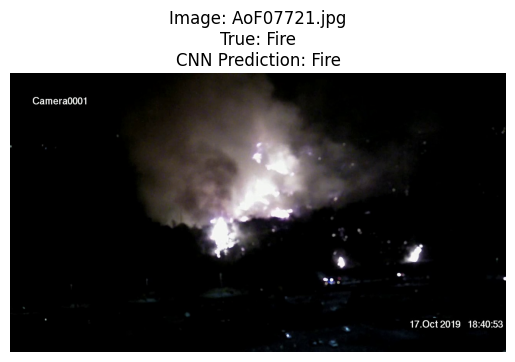


--- Processing single image: AoF07731.jpg ---
True Label: Fire (1)
CNN Prediction: Fire


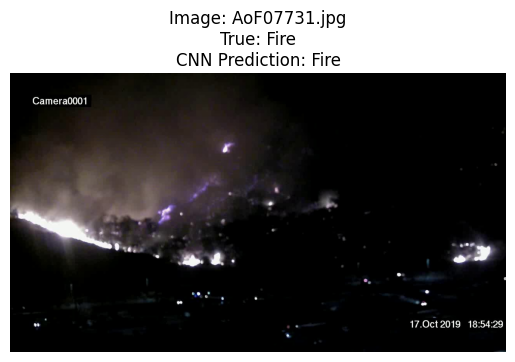


--- Processing single image: AoF07736.jpg ---
True Label: Fire (1)
CNN Prediction: Fire


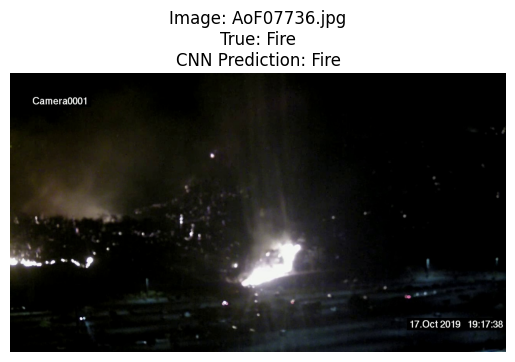


--- Processing single image: AoF07749.jpg ---
True Label: Fire (1)
CNN Prediction: Fire


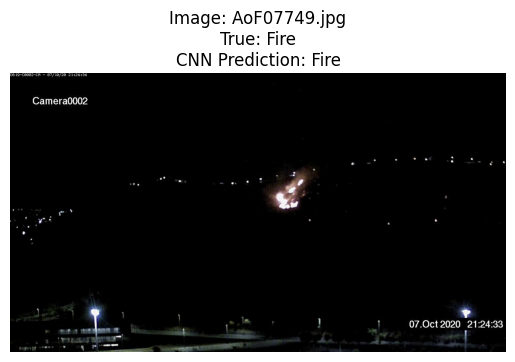


--- Processing single image: AoF07753.jpg ---
True Label: Fire (1)
CNN Prediction: Fire


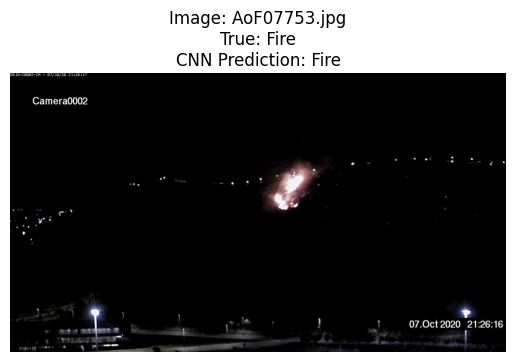


--- Processing 5 sample non-fire images ---

--- Processing single image: AoF06729.jpg ---
True Label: Non-Fire (0)
CNN Prediction: Fire


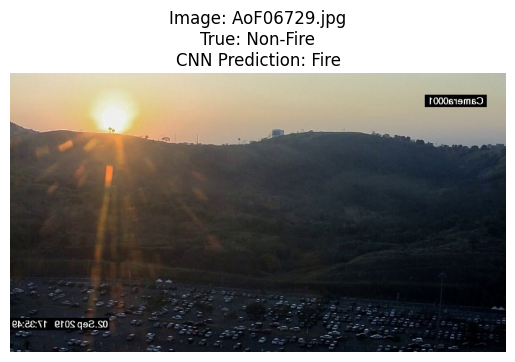


--- Processing single image: AoF06730.jpg ---
True Label: Non-Fire (0)
CNN Prediction: Non-Fire


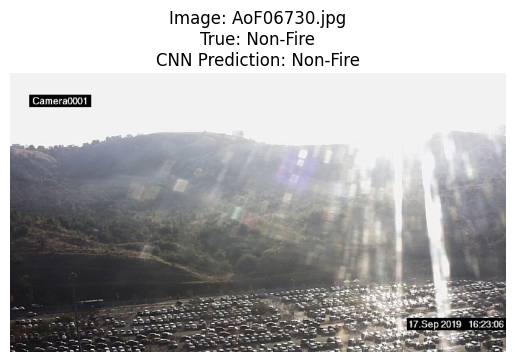


--- Processing single image: AoF06733.jpg ---
True Label: Non-Fire (0)
CNN Prediction: Non-Fire


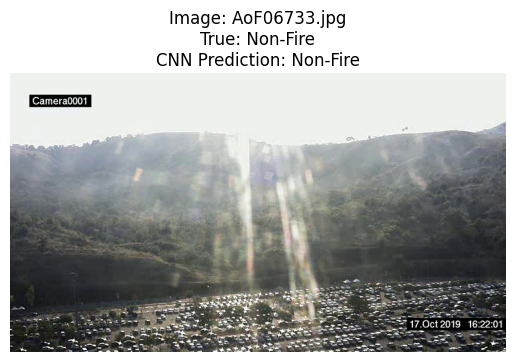


--- Processing single image: AoF06736.jpg ---
True Label: Non-Fire (0)
CNN Prediction: Fire


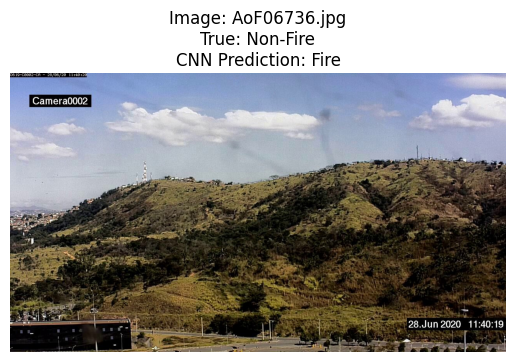


--- Processing single image: AoF06741.jpg ---
True Label: Non-Fire (0)
CNN Prediction: Non-Fire


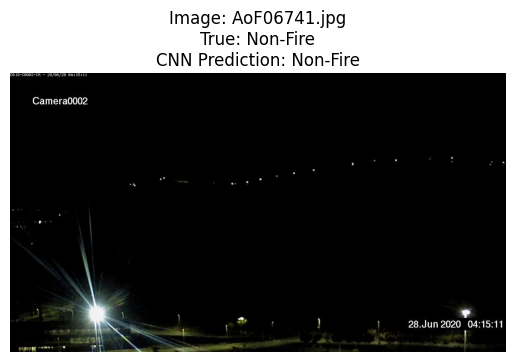

In [ ]:
if __name__ == "__main__":
    print(f"Starting D-Fire CNN evaluation script.")
    print(f"DFIRE_ROOT set to: {DFIRE_ROOT}")
    print(f"DFIRE_TEST_ROOT set to: {DFIRE_TEST_ROOT}")
    print(f"MODEL_DIR set to: {MODEL_DIR}")
    artifacts = load_all_artifacts('DFire', DFIRE_CONFIG)

    if artifacts and artifacts['cnn_model'] is not None:
        print("\n--- CNN Model loaded successfully. Proceeding with evaluations. ---")
        reproduce_original_test_results(artifacts, DFIRE_ROOT, DFIRE_CONFIG)
        evaluate_folder(DFIRE_TEST_IMAGES_DIR, DFIRE_TEST_LABELS_DIR, artifacts, DFIRE_CONFIG)
        print("\n--- Preparing sample images for single image processing ---")
        all_test_images, all_test_labels = load_prep_4_cnn(DFIRE_TEST_ROOT, DFIRE_CONFIG)
        if all_test_images.size == 0:
            print("No test data loaded for single image processing. Skipping.")
        else:
            test_image_filenames = [f for f in os.listdir(DFIRE_TEST_IMAGES_DIR) if f.lower().endswith(DFIRE_CONFIG['img_extensions'])]
            test_image_filenames.sort()
            fire_image_paths_for_display = []
            non_fire_image_paths_for_display = []

            for idx, label in enumerate(all_test_labels):
                if idx < len(test_image_filenames):
                    image_name = test_image_filenames[idx]
                    image_path = os.path.join(DFIRE_TEST_IMAGES_DIR, image_name)
                    if label == 1: fire_image_paths_for_display.append(image_path)
                    else: non_fire_image_paths_for_display.append(image_path)
                else:
                    print(f"Warning: Mismatch between loaded labels count ({len(all_test_labels)}) and image filenames count ({len(test_image_filenames)}).")
                    break

            num_samples_to_show = min(5, len(fire_image_paths_for_display))
            if num_samples_to_show > 0:
                print(f"\n--- Processing {num_samples_to_show} sample fire images ---")
                for i in range(num_samples_to_show):
                    sample_fire_image = fire_image_paths_for_display[i]
                    process_single_image(sample_fire_image, DFIRE_TEST_LABELS_DIR, artifacts, DFIRE_CONFIG)
            else:
                print("\nNo fire images identified in the test set for single image processing.")

            num_samples_to_show = min(5, len(non_fire_image_paths_for_display)) # Show up to 5 examples
            if num_samples_to_show > 0:
                print(f"\n--- Processing {num_samples_to_show} sample non-fire images ---")
                for i in range(num_samples_to_show):
                    sample_non_fire_image = non_fire_image_paths_for_display[i]
                    process_single_image(sample_non_fire_image, DFIRE_TEST_LABELS_DIR, artifacts, DFIRE_CONFIG)
            else:
                print("\nNo non-fire images identified in the test set for single image processing.")

    else: pass